## Crypto Prediction with LSTM: Litecoin (LTC)

## 30 Day Lookback

- This notebook attempts to use TensorFlow Keras LSTM to predict movement in Crypto prices
- Data is pulled from the CoinApi, so it can be refreshed at any point and retrained
- 2 optimizations were used and an overall R2 score of .86 was attained
- This update uses a 30 day lookback window, in order to assess whether the greater lookback time has an impact on training and prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt


from api_keys import coinapi_key

In [2]:
# Pull LTC data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_LTC_USD/history?period_id=1DAY&limit=20000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-11-05T00:00:00.0000000Z', 'time_period_end': '2023-11-06T00:00:00.0000000Z', 'time_open': '2023-11-05T00:00:06.6680000Z', 'time_close': '2023-11-05T23:22:58.1820000Z', 'price_open': 70.46, 'price_high': 72.3, 'price_low': 70.04, 'price_close': 71.82, 'volume_traded': 16360.36621946, 'trades_count': 1591}, {'time_period_start': '2023-11-04T00:00:00.0000000Z', 'time_period_end': '2023-11-05T00:00:00.0000000Z', 'time_open': '2023-11-04T00:03:26.6090000Z', 'time_close': '2023-11-04T23:59:56.4770000Z', 'price_open': 69.36, 'price_high': 70.99, 'price_low': 68.83, 'price_close': 70.46, 'volume_traded': 3754.01056449, 'trades_count': 787}, {'time_period_start': '2023-11-03T00:00:00.0000000Z', 'time_period_end': '2023-11-04T00:00:00.0000000Z', 'time_open': '2023-11-03T00:07:03.6080000Z', 'time_close': '2023-11-03T23:52:56.8610000Z', 'price_open': 69.09, 'price_high': 69.54, 'price_low': 67.56, 'price_close': 69.5, 'volume_traded': 6053.19198561, 'trades_count': 142

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-11-05T00:00:00.0000000Z,2023-11-06T00:00:00.0000000Z,2023-11-05T00:00:06.6680000Z,2023-11-05T23:22:58.1820000Z,70.46,72.30,70.04,71.82,16360.366219,1591
1,2023-11-04T00:00:00.0000000Z,2023-11-05T00:00:00.0000000Z,2023-11-04T00:03:26.6090000Z,2023-11-04T23:59:56.4770000Z,69.36,70.99,68.83,70.46,3754.010564,787
2,2023-11-03T00:00:00.0000000Z,2023-11-04T00:00:00.0000000Z,2023-11-03T00:07:03.6080000Z,2023-11-03T23:52:56.8610000Z,69.09,69.54,67.56,69.50,6053.191986,1422
3,2023-11-02T00:00:00.0000000Z,2023-11-03T00:00:00.0000000Z,2023-11-02T00:08:35.4500000Z,2023-11-02T23:44:20.5870000Z,69.99,70.73,67.43,69.33,10879.146611,1951
4,2023-11-01T00:00:00.0000000Z,2023-11-02T00:00:00.0000000Z,2023-11-01T00:16:39.0330000Z,2023-11-01T23:58:21.9550000Z,69.12,70.35,66.56,69.97,7609.154459,1783


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data.head()

,Close
Date,
2017-06-28,42.04
2017-06-29,40.50
2017-06-30,39.88
2017-07-01,38.10
2017-07-02,41.42


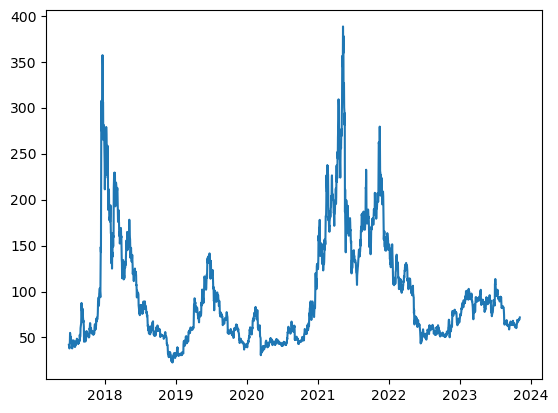

In [5]:
#plot historical ltc price
plt.plot(data)

In [6]:
# Set parameters for model

lookback = 30 

split_1 = .8
split_2 = .9

In [7]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(data, lookback)

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

#scale data
log_transformed_data = np.log(shifted_df_as_np)



# split y from features
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape

((2279, 30), (2279,), (2279,))

In [8]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1823, 30), (1823,), (228, 30), (228,), (228, 30), (228,))

In [9]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100)

Epoch 1/100


2023-11-05 18:31:25.592209: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


57/57 [==============================] - 1s 11ms/step - loss: 3.4351 - mean_absolute_error: 1.3468 - val_loss: 0.0487 - val_mean_absolute_error: 0.1947
Epoch 2/100
57/57 [==============================] - 0s 8ms/step - loss: 0.2470 - mean_absolute_error: 0.4143 - val_loss: 0.0144 - val_mean_absolute_error: 0.1039
Epoch 3/100
57/57 [==============================] - 0s 9ms/step - loss: 0.0484 - mean_absolute_error: 0.1645 - val_loss: 0.0105 - val_mean_absolute_error: 0.0817
Epoch 4/100
57/57 [==============================] - 0s 8ms/step - loss: 0.0217 - mean_absolute_error: 0.1069 - val_loss: 0.0050 - val_mean_absolute_error: 0.0540
Epoch 5/100
57/57 [==============================] - 0s 6ms/step - loss: 0.0158 - mean_absolute_error: 0.0900 - val_loss: 0.0057 - val_mean_absolute_error: 0.0592
Epoch 6/100
57/57 [==============================] - 0s 7ms/step - loss: 0.0138 - mean_absolute_error: 0.0855 - val_loss: 0.0045 - val_mean_absolute_error: 0.0504
Epoch 7/100
57/57 [==============

57/57 [==============================] - 0s 2ms/step


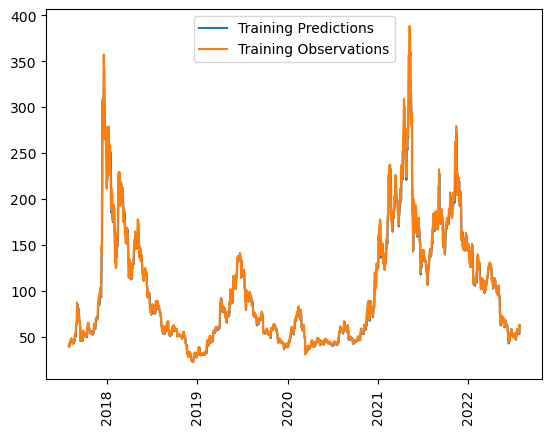

In [10]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [11]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0019284362206235528
Val MAE: 0.031088413670659065


8/8 [==============================] - 0s 2ms/step


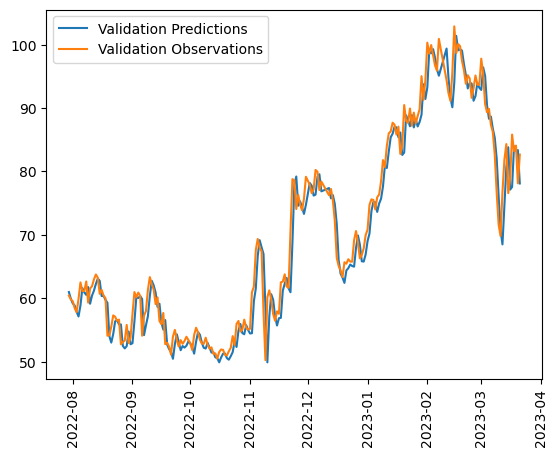

In [12]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, np.exp(val_predictions))
plt.plot(dates_val1, np.exp(y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [13]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0012905739713460207
Test MAE: 0.025276750326156616


8/8 [==============================] - 0s 2ms/step


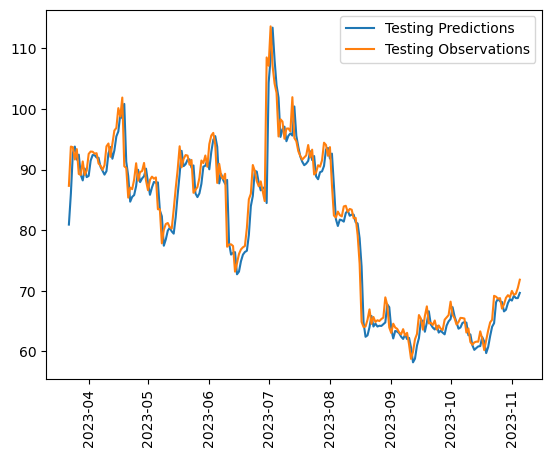

In [14]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1, np.exp(test_predictions))
plt.plot(dates_test1, np.exp(y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [15]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  0.9531826514647221


## Optimization of the Model

- Adjust the initial data used, limited to the last 50% of the data
- Focus more on recent trends for learning
- Increase Epochs
- Slow learning rate

In [16]:
# Split is changed to begin at 50% of the dataset and continue to the end.
split_1 = .5
split_2 = .89
split_3 = .95


initial_split = int(len(X1) * split_1)
train_split = int(len(X1) * split_2)
test_split = int(len(X1) * split_3)

In [17]:
#change timeframe

dates_train2, X_train2, y_train2 = dates[initial_split:train_split],X1[initial_split:train_split], y1[initial_split:train_split]
dates_val2, X_val2, y_val2 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test2, X_test2, y_test2 = dates[test_split:], X1[test_split:], y1[test_split:]
dates_train2.shape, X_train2.shape, y_train2.shape, \
dates_val2.shape, X_val2.shape, y_val2.shape, \
dates_test2.shape, X_test2.shape, y_test2.shape

((889,),
 (889, 30),
 (889,),
 (137,),
 (137, 30),
 (137,),
 (114,),
 (114, 30),
 (114,))

In [18]:
# Build, compile and fit the new model- increased epochs, smaller learning rate
model2 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300)

Epoch 1/300
57/57 [==============================] - 1s 8ms/step - loss: 5.6211 - mean_absolute_error: 1.8184 - val_loss: 0.0413 - val_mean_absolute_error: 0.1827
Epoch 2/300
57/57 [==============================] - 0s 6ms/step - loss: 0.2878 - mean_absolute_error: 0.4636 - val_loss: 0.0561 - val_mean_absolute_error: 0.1975
Epoch 3/300
57/57 [==============================] - 0s 6ms/step - loss: 0.0815 - mean_absolute_error: 0.2200 - val_loss: 0.0915 - val_mean_absolute_error: 0.2747
Epoch 4/300
57/57 [==============================] - 0s 6ms/step - loss: 0.0368 - mean_absolute_error: 0.1432 - val_loss: 0.0077 - val_mean_absolute_error: 0.0665
Epoch 5/300
57/57 [==============================] - 0s 6ms/step - loss: 0.0175 - mean_absolute_error: 0.0972 - val_loss: 0.0048 - val_mean_absolute_error: 0.0527
Epoch 6/300
57/57 [==============================] - 0s 6ms/step - loss: 0.0119 - mean_absolute_error: 0.0771 - val_loss: 0.0035 - val_mean_absolute_error: 0.0444
Epoch 7/300
57/57 [===

57/57 [==============================] - 1s 24ms/step - loss: 0.0042 - mean_absolute_error: 0.0473 - val_loss: 0.0017 - val_mean_absolute_error: 0.0299
Epoch 200/300
57/57 [==============================] - 1s 26ms/step - loss: 0.0042 - mean_absolute_error: 0.0478 - val_loss: 0.0016 - val_mean_absolute_error: 0.0288
Epoch 201/300
57/57 [==============================] - 2s 28ms/step - loss: 0.0049 - mean_absolute_error: 0.0520 - val_loss: 0.0016 - val_mean_absolute_error: 0.0292
Epoch 202/300
57/57 [==============================] - 2s 27ms/step - loss: 0.0041 - mean_absolute_error: 0.0469 - val_loss: 0.0021 - val_mean_absolute_error: 0.0337
Epoch 203/300
57/57 [==============================] - 2s 27ms/step - loss: 0.0040 - mean_absolute_error: 0.0457 - val_loss: 0.0016 - val_mean_absolute_error: 0.0284
Epoch 204/300
57/57 [==============================] - 1s 26ms/step - loss: 0.0037 - mean_absolute_error: 0.0431 - val_loss: 0.0025 - val_mean_absolute_error: 0.0402
Epoch 205/300
57/5

57/57 [==============================] - 2s 26ms/step - loss: 0.0037 - mean_absolute_error: 0.0425 - val_loss: 0.0016 - val_mean_absolute_error: 0.0289
Epoch 249/300
57/57 [==============================] - 2s 30ms/step - loss: 0.0039 - mean_absolute_error: 0.0453 - val_loss: 0.0016 - val_mean_absolute_error: 0.0285
Epoch 250/300
57/57 [==============================] - 2s 27ms/step - loss: 0.0036 - mean_absolute_error: 0.0424 - val_loss: 0.0017 - val_mean_absolute_error: 0.0293
Epoch 251/300
57/57 [==============================] - 2s 29ms/step - loss: 0.0045 - mean_absolute_error: 0.0493 - val_loss: 0.0045 - val_mean_absolute_error: 0.0585
Epoch 252/300
57/57 [==============================] - 2s 34ms/step - loss: 0.0039 - mean_absolute_error: 0.0456 - val_loss: 0.0022 - val_mean_absolute_error: 0.0340
Epoch 253/300
57/57 [==============================] - 2s 31ms/step - loss: 0.0037 - mean_absolute_error: 0.0428 - val_loss: 0.0016 - val_mean_absolute_error: 0.0286
Epoch 254/300
57/5

57/57 [==============================] - 3s 48ms/step - loss: 0.0037 - mean_absolute_error: 0.0436 - val_loss: 0.0033 - val_mean_absolute_error: 0.0469
Epoch 298/300
57/57 [==============================] - 3s 51ms/step - loss: 0.0040 - mean_absolute_error: 0.0451 - val_loss: 0.0030 - val_mean_absolute_error: 0.0443
Epoch 299/300
57/57 [==============================] - 3s 59ms/step - loss: 0.0044 - mean_absolute_error: 0.0478 - val_loss: 0.0038 - val_mean_absolute_error: 0.0518
Epoch 300/300
57/57 [==============================] - 3s 51ms/step - loss: 0.0039 - mean_absolute_error: 0.0444 - val_loss: 0.0019 - val_mean_absolute_error: 0.0312


57/57 [==============================] - 0s 2ms/step


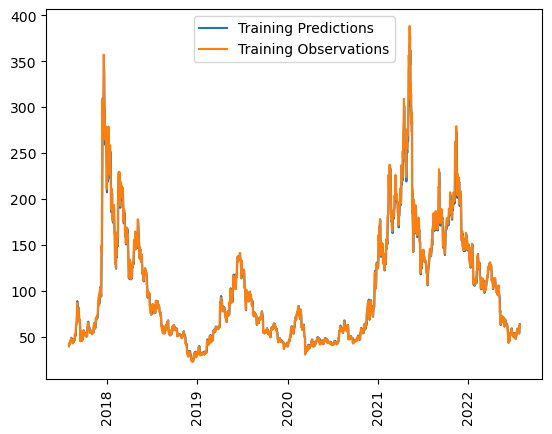

In [19]:
#Second model observations
train_predictions2 = model2.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions2))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [20]:
score = model2.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0018668362172320485
Val MAE: 0.02932824194431305


5/5 [==============================] - 0s 2ms/step


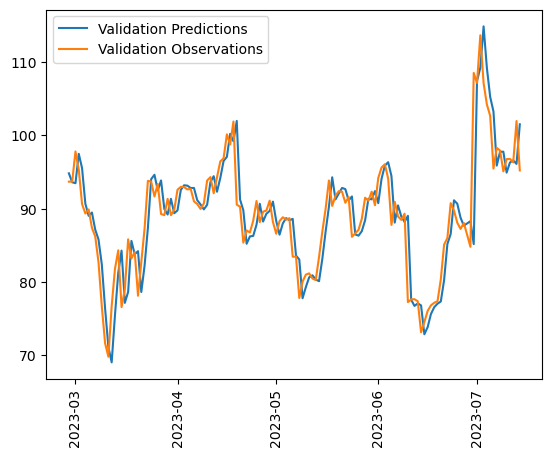

In [21]:
#Second model observations
val_predictions2 = model2.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions2))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [22]:
#MSAE Score for second model
score = model2.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0007018217002041638
Test MAE: 0.01842431351542473


In [23]:
# R2 score for second model
y_pred = model2.predict(X_test2)
print('R2 Score: ', r2_score(y_test2, y_pred))

4/4 [==============================] - 0s 2ms/step
R2 Score:  0.966092058936462


4/4 [==============================] - 0s 2ms/step


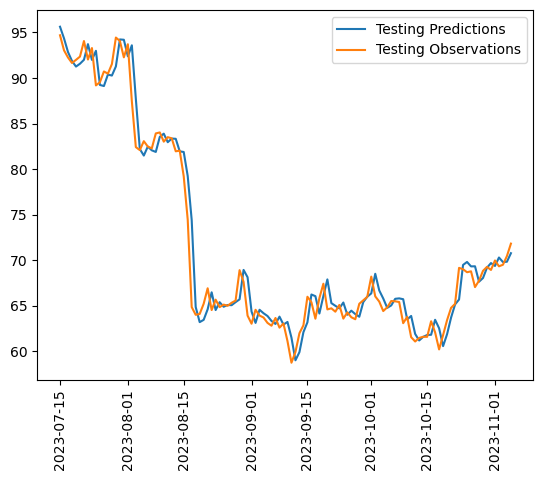

In [24]:
#Second model observations
test_predictions2 = model2.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions2))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [25]:
# Second optimization. Increased neural density, epochs
model3 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=300)

Epoch 1/300
28/28 [==============================] - 1s 16ms/step - loss: 19.5765 - mean_absolute_error: 4.3905 - val_loss: 15.4673 - val_mean_absolute_error: 3.9320
Epoch 2/300
28/28 [==============================] - 0s 6ms/step - loss: 15.6748 - mean_absolute_error: 3.9248 - val_loss: 12.5389 - val_mean_absolute_error: 3.5401
Epoch 3/300
28/28 [==============================] - 0s 6ms/step - loss: 12.4231 - mean_absolute_error: 3.4850 - val_loss: 9.0263 - val_mean_absolute_error: 3.0032
Epoch 4/300
28/28 [==============================] - 0s 6ms/step - loss: 8.4130 - mean_absolute_error: 2.8476 - val_loss: 5.1271 - val_mean_absolute_error: 2.2628
Epoch 5/300
28/28 [==============================] - 0s 6ms/step - loss: 4.3154 - mean_absolute_error: 1.9958 - val_loss: 1.6293 - val_mean_absolute_error: 1.2736
Epoch 6/300
28/28 [==============================] - 0s 6ms/step - loss: 1.3732 - mean_absolute_error: 1.0251 - val_loss: 0.1770 - val_mean_absolute_error: 0.4122
Epoch 7/300
28/2

28/28 [==============================] - 1s 36ms/step - loss: 0.0050 - mean_absolute_error: 0.0517 - val_loss: 0.0028 - val_mean_absolute_error: 0.0387
Epoch 200/300
28/28 [==============================] - 1s 43ms/step - loss: 0.0049 - mean_absolute_error: 0.0511 - val_loss: 0.0027 - val_mean_absolute_error: 0.0373
Epoch 201/300
28/28 [==============================] - 1s 41ms/step - loss: 0.0047 - mean_absolute_error: 0.0494 - val_loss: 0.0028 - val_mean_absolute_error: 0.0386
Epoch 202/300
28/28 [==============================] - 1s 46ms/step - loss: 0.0048 - mean_absolute_error: 0.0501 - val_loss: 0.0031 - val_mean_absolute_error: 0.0413
Epoch 203/300
28/28 [==============================] - 1s 48ms/step - loss: 0.0050 - mean_absolute_error: 0.0524 - val_loss: 0.0028 - val_mean_absolute_error: 0.0397
Epoch 204/300
28/28 [==============================] - 1s 41ms/step - loss: 0.0046 - mean_absolute_error: 0.0498 - val_loss: 0.0034 - val_mean_absolute_error: 0.0449
Epoch 205/300
28/2

28/28 [==============================] - 1s 26ms/step - loss: 0.0042 - mean_absolute_error: 0.0469 - val_loss: 0.0027 - val_mean_absolute_error: 0.0381
Epoch 249/300
28/28 [==============================] - 1s 27ms/step - loss: 0.0043 - mean_absolute_error: 0.0476 - val_loss: 0.0024 - val_mean_absolute_error: 0.0342
Epoch 250/300
28/28 [==============================] - 1s 28ms/step - loss: 0.0041 - mean_absolute_error: 0.0453 - val_loss: 0.0024 - val_mean_absolute_error: 0.0341
Epoch 251/300
28/28 [==============================] - 1s 26ms/step - loss: 0.0043 - mean_absolute_error: 0.0466 - val_loss: 0.0029 - val_mean_absolute_error: 0.0401
Epoch 252/300
28/28 [==============================] - 1s 28ms/step - loss: 0.0043 - mean_absolute_error: 0.0478 - val_loss: 0.0035 - val_mean_absolute_error: 0.0462
Epoch 253/300
28/28 [==============================] - 1s 25ms/step - loss: 0.0047 - mean_absolute_error: 0.0505 - val_loss: 0.0025 - val_mean_absolute_error: 0.0360
Epoch 254/300
28/2

28/28 [==============================] - 1s 37ms/step - loss: 0.0037 - mean_absolute_error: 0.0434 - val_loss: 0.0033 - val_mean_absolute_error: 0.0455
Epoch 298/300
28/28 [==============================] - 1s 46ms/step - loss: 0.0038 - mean_absolute_error: 0.0441 - val_loss: 0.0024 - val_mean_absolute_error: 0.0353
Epoch 299/300
28/28 [==============================] - 1s 26ms/step - loss: 0.0039 - mean_absolute_error: 0.0449 - val_loss: 0.0023 - val_mean_absolute_error: 0.0339
Epoch 300/300
28/28 [==============================] - 1s 27ms/step - loss: 0.0038 - mean_absolute_error: 0.0442 - val_loss: 0.0023 - val_mean_absolute_error: 0.0347


28/28 [==============================] - 0s 2ms/step


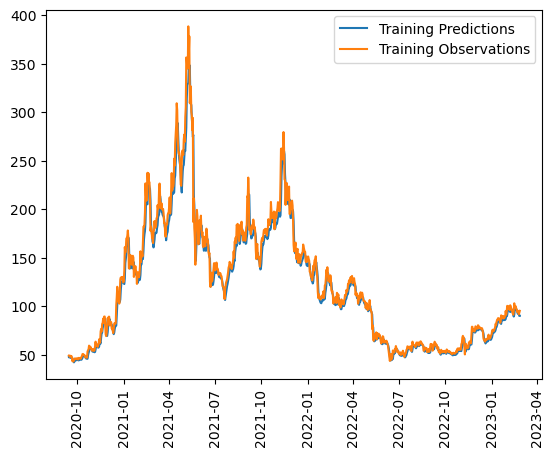

In [26]:
#Third model observations
train_predictions3 = model3.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions3))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [27]:
score = model3.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0030126923229545355
Val MAE: 0.0430019274353981


5/5 [==============================] - 0s 2ms/step


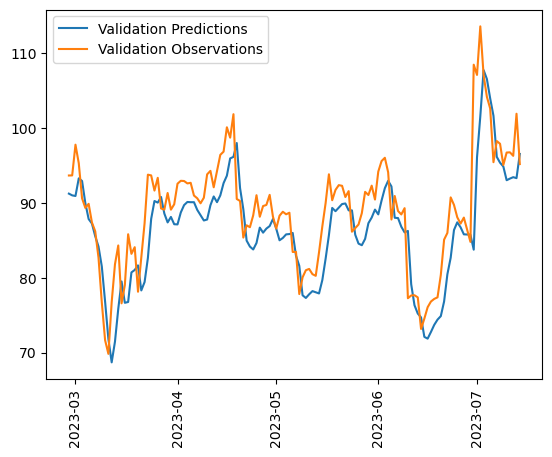

In [28]:
#Second model observations 
val_predictions3 = model3.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions3))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [29]:
# Third Model MAE score
score = model3.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0015740826493129134
Test MAE: 0.03345233574509621


4/4 [==============================] - 0s 2ms/step


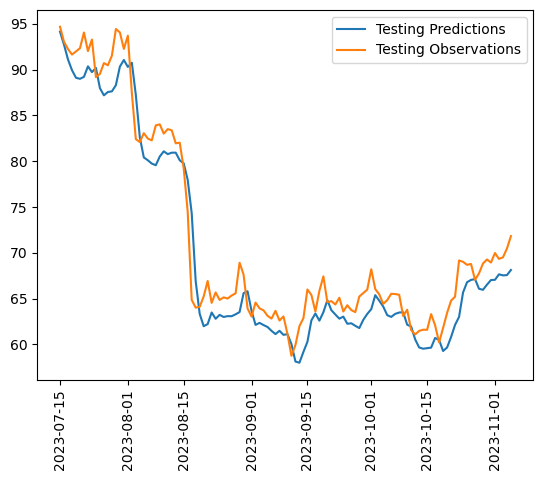

In [30]:
test_predictions3 = model3.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions3))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [31]:
# R2 score for second model

print('R2 Score: ', r2_score(y_test2, test_predictions3))

R2 Score:  0.9239495194889402


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends
- We are using the highest scoring model for future predictions

In [32]:
# Use the first model to predict future values since it has the highest r2 score

# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 7

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test1[-1]
current_reshape = current_batch.reshape((1, lookback))
initial_date = dates_test1[-1]

# Generate predictions for 7 days
for i in range(prediction_range): # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        

    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, lookback))

# add future dates for predictions
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# 'predictions' contains 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 8ms/step
[4.2433305, 4.243737, 4.2437057, 4.2435517, 4.243426, 4.243342, 4.2432866]
2023-11-06
2023-11-07
2023-11-08
2023-11-09
2023-11-10
2023-11-11
2023-11-12


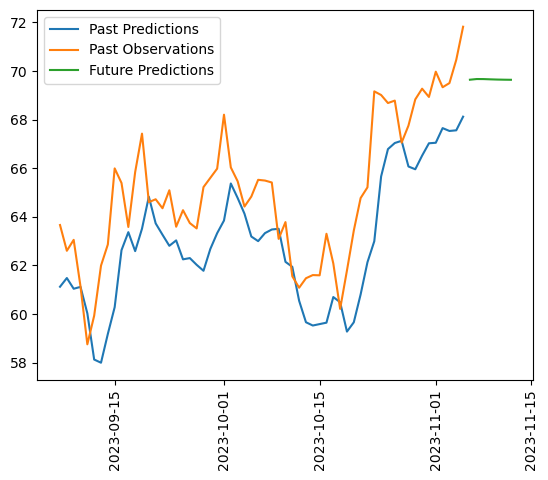

In [33]:
#Plot last 60 days of testing plus future prediction
plt.plot(dates_test2[-60:], np.exp(test_predictions3[-60:]))
plt.plot(dates_test2[-60:],np.exp(y_test2[-60:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [34]:
# Export model to HDF5 file
model.save("H5_Files/ltc_30_day_1.h5")

In [35]:
# Export model to HDF5 file
model2.save("H5_Files/ltc_30_day_2.h5")

In [36]:
# Export model to HDF5 file
model3.save("H5_Files/ltc_30_day_3.h5")

In [37]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates_test2[-90:], "observed":np.exp(y_test2[-90:]),\
                "model_1_predicted":np.exp(test_predictions[-90:]),\
                "model_2_predicted":np.exp(test_predictions2[-90:]),\
                "model_3_predicted":np.exp(test_predictions3[-90:])})
df.set_index('Date', inplace=True)


df


,observed,model_1_predicted,model_2_predicted,model_3_predicted
Date,,,,
2023-08-08,83.91,81.405060,81.878876,79.556099
2023-08-09,84.02,82.808174,83.528755,80.510353
2023-08-10,83.01,83.250969,83.886948,81.074776
2023-08-11,83.50,82.370407,82.947716,80.770058
2023-08-12,83.37,82.563568,83.347565,80.928001
...,...,...,...,...
2023-11-01,69.97,68.372543,69.366577,67.044662
2023-11-02,69.33,69.166557,70.295006,67.647614
2023-11-03,69.50,68.782539,69.797577,67.530685


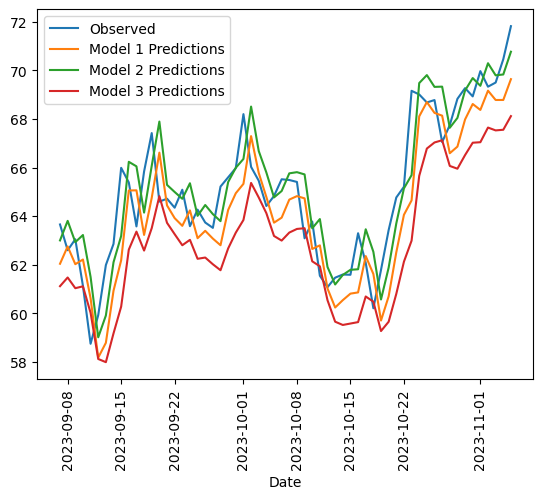

In [38]:
#Measuring each model's predictions against the test data
df[-60:].plot(use_index=True)
plt.xticks(rotation=90)

plt.legend(['Observed', 'Model 1 Predictions', 'Model 2 Predictions', \
            'Model 3 Predictions'])
plt.show()

In [39]:
#output prediction data to csv
df.to_csv('output/ltc_predict_30.csv') 

In [40]:
#output original historical data to csv
data.to_csv('output/ltc_lifetime_30.csv')

In [41]:
#Scores for each model

print('Model 1 R2 Score: ', r2_score(y_test1, test_predictions))
print('Model 2 R2 Score: ', r2_score(y_test2, test_predictions2))
print('Model 3 R2 Score: ', r2_score(y_test2, test_predictions3))

Model 1 R2 Score:  0.9531826514647221
Model 2 R2 Score:  0.966092058936462
Model 3 R2 Score:  0.9239495194889402
